In [65]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")

color_names = ["windows blue",
               "red",
               "medium green",
               "dusty purple",
               "orange",
               "greyish"]
colors = sns.xkcd_palette(color_names)

%matplotlib inline

In [3]:
# Construct a simple latent Hawkes process with 
# one latent node with constant rate.
T = 20
b_latent = 1.0

def sample_homog_pp(lmbda, T):
    N = npr.poisson(lmbda * T)
    ts = T * npr.rand(N)
    return ts

S = sample_homog_pp(b_latent, T)

# Sample the parameters, theta, associated with each latent event
# In this model, assume the params are the means of a Gaussian obs
Theta = npr.normal(0, 1, size=(S.size))

In [93]:
len(S)

25

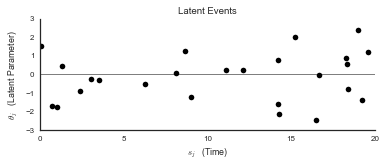

In [7]:
plt.figure(figsize=(6,2))
plt.plot(S, Theta, 'ko')
plt.plot([0,T], [0,0], '-k', lw=0.5)
plt.xlabel("$s_j$   (Time)")
plt.ylabel("$\\theta_j$   (Latent Parameter)")
plt.title("Latent Events")
sns.despine()

In [70]:
# Assume there are N observed nodes
# and each has a weighted dependence on the latent data
N = 3
W = npr.gamma(2,2,size=N)
# W = np.ones(3)
b = 0.5 * np.ones(N)

# Assume the impulse responses are exponential distributions
tau = 1
def sample_exp_pp(w, tau, offset):
    N = npr.poisson(w)
    ts = npr.exponential(scale=tau)
    ts += offset
    ts = ts[ts < T]
    return ts

# Assume the conditional distribution x | th = N(x | th, sigma)
sigma = 0.5

D = []
for n in range(N):
    # Sample background
    Tn = sample_homog_pp(b[n], T)
    Xn = npr.normal(0, 1.0, size=len(Tn))
    Zn = np.zeros(len(Tn))
    
    for j, (s, th) in enumerate(zip(S, Theta)):
        # Sample times 
        Tsn = sample_exp_pp(W[n], tau, s)
        Tn = np.concatenate((Tn, Tsn))
        
        # Sample observations
        Xsn = npr.normal(th, sigma, size=(len(Tsn)))
        Xn = np.concatenate((Xn, Xsn))
        
        # Set parents
        Zsn = (j+1)* np.ones(len(Tsn))
        Zn = np.concatenate((Zn, Zsn))
        
    # Append data
    D.append((Tn, Xn, Zn))
    


In [79]:
# Compute the rates for each node
xx = np.linspace(4,-4, 100)
tt = np.linspace(0,T, 100)
xx, tt = np.meshgrid(xx, tt)

def normal_pdf(x,mu,sig):
    return 1./np.sqrt(2*np.pi*sig**2) * np.exp(-0.5 * (x-mu)**2 / sig**2)

Lmbdas = []
for n in range(N):
    Lmbda_n = np.zeros_like(xx)
    Lmbda_n += b[n]
    for s, th in zip(S, Theta):
        dt = tt-s
        Lmbda_n += W[n] * 1./tau * np.exp(-dt/tau) * normal_pdf(xx, th, sigma) * (tt > s)
    Lmbdas.append(Lmbda_n)

vmin = np.min(np.array(Lmbdas))
vmax = np.max(np.array(Lmbdas))


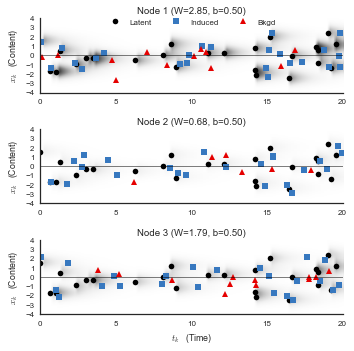

In [96]:
plt.figure(figsize=(5,5))

# plt.subplot(N+1,1,1)
# plt.plot(S, Theta, 'ko')
# plt.imshow(Lmbdas[n].T, vmin=vmin, vmax=vmax, extent=(0,T,-4,4), aspect="auto", cmap="Blues")
# # plt.ylim(4,-4)
# plt.plot([0,T], [0,0], '-k', lw=0.5)
# plt.xlabel("$s_j$   (Time)")
# plt.ylabel("$\\theta_j$   (Latent Parameter)")
# plt.title("Latent Events")
sns.despine()

for n in range(N):
    Tn, Xn, Zn = D[n]
    
    plt.subplot(N, 1, n+1)
    plt.imshow(Lmbdas[n].T, vmin=vmin, vmax=vmax, 
               extent=(0,T,-4,4), aspect="auto", cmap="Greys")
    
    # Plot the latent points
    plt.plot(S, Theta, 'ko', label="Latent")
    
    # Plot the induced points
    plt.plot(Tn[Zn>0], Xn[Zn>0], 's', color=colors[0], label="Induced")
    plt.plot(Tn[Zn==0], Xn[Zn==0], '^', color=colors[1], label="Bkgd")
    plt.plot([0,T], [0,0], '-k', lw=0.5)
    
    if n == 0:
        plt.legend(loc="upper center", bbox_to_anchor=[0.5,1.0,0,0.1], ncol=3)
    if n == N-1:
        plt.xlabel("$t_k$   (Time)")
    plt.ylabel("$x_k$   (Content)")
    plt.title("Node {0} (W={1:.2f}, b={2:.2f})".format(n+1, W[n], b[n]))
    sns.despine()
    
plt.tight_layout()
plt.savefig("latent_hawkes_example.pdf")
